In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define Learning Parameters

In [16]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare Training Dataset

In [17]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Generator

In [18]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [20]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [21]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.002)


# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator


In [22]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [23]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [24]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [25]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [26]:
print("generator weights: ")
for param in generator.parameters():
    print(param.data)

generator weights: 
tensor([[ 0.0188, -0.0591,  0.0387,  ..., -0.0679,  0.0169,  0.0221],
        [-0.0750,  0.0495, -0.0098,  ...,  0.0776, -0.0325,  0.0622],
        [ 0.0618, -0.0206,  0.0252,  ..., -0.0599,  0.0452, -0.0087],
        ...,
        [ 0.0531,  0.0394,  0.0232,  ..., -0.0590, -0.0192,  0.0811],
        [-0.0472,  0.0591, -0.0338,  ..., -0.0163,  0.0152, -0.0197],
        [-0.0602,  0.0785, -0.0631,  ..., -0.0367, -0.0426, -0.0511]])
tensor([-0.0514,  0.0555,  0.0364,  0.0832,  0.0785, -0.0041,  0.0360, -0.0633,
        -0.0083,  0.0011,  0.0184,  0.0115, -0.0269, -0.0489, -0.0246,  0.0846,
         0.0077,  0.0696, -0.0475,  0.0191, -0.0739, -0.0228, -0.0574,  0.0134,
        -0.0519, -0.0009,  0.0202, -0.0876,  0.0010, -0.0823,  0.0424,  0.0555,
         0.0062, -0.0228, -0.0265,  0.0137,  0.0212, -0.0362, -0.0780,  0.0704,
         0.0589,  0.0510, -0.0776,  0.0098, -0.0241, -0.0537, -0.0262, -0.0593,
        -0.0620, -0.0620, -0.0578, -0.0799, -0.0095, -0.0056,  0.0

In [27]:
print("discriminator weights: ")
for param in discriminator.parameters():
    print(param.data)

discriminator weights: 
tensor([[-1.3423e-03,  4.4861e-03, -3.0958e-02,  ..., -2.7151e-02,
          3.0420e-02,  2.0709e-02],
        [-4.4026e-03, -2.0501e-02,  1.1727e-02,  ..., -1.0833e-02,
          3.9130e-03, -1.8604e-02],
        [ 1.6854e-02, -7.1859e-03,  2.9094e-02,  ..., -2.6585e-02,
          1.7144e-02, -2.2787e-02],
        ...,
        [-2.9892e-02,  3.4008e-02,  3.3793e-02,  ..., -2.0484e-02,
         -2.1309e-05,  2.0342e-02],
        [ 1.1795e-02, -2.4173e-02,  1.1864e-02,  ...,  9.7840e-03,
          2.1875e-02,  1.7494e-02],
        [ 3.1229e-02, -2.7906e-02, -1.4435e-02,  ..., -2.3611e-02,
          1.2793e-02,  3.0803e-02]])
tensor([-0.0117,  0.0084,  0.0208,  ...,  0.0229, -0.0189, -0.0199])
tensor([[ 0.0017,  0.0164,  0.0028,  ...,  0.0278, -0.0129, -0.0188],
        [-0.0196, -0.0302,  0.0214,  ..., -0.0283,  0.0222, -0.0310],
        [-0.0295,  0.0059,  0.0049,  ..., -0.0024,  0.0194, -0.0075],
        ...,
        [ 0.0092,  0.0283,  0.0051,  ..., -0.0153, -

# Write Training Loop

118it [00:16,  7.27it/s]                         


Epoch 1 of 100
Generator loss: 0.61597425, Discriminator loss: 1.06198239


118it [00:19,  6.20it/s]                         


Epoch 2 of 100
Generator loss: 0.72841233, Discriminator loss: 0.72570360


118it [00:19,  6.19it/s]                         


Epoch 3 of 100
Generator loss: 0.67059046, Discriminator loss: 0.79263306


118it [00:17,  6.66it/s]                         


Epoch 4 of 100
Generator loss: 0.69936186, Discriminator loss: 0.69929588


118it [00:20,  5.77it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


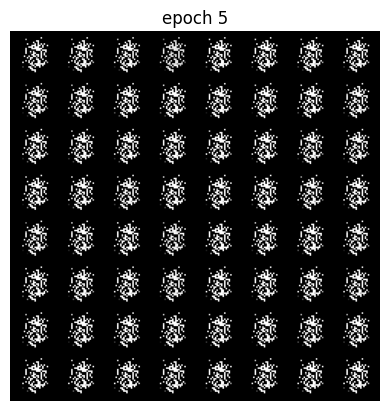

Epoch 5 of 100
Generator loss: 0.69444233, Discriminator loss: 0.69267893


118it [00:20,  5.74it/s]                         


Epoch 6 of 100
Generator loss: 0.69446772, Discriminator loss: 0.69266331


118it [00:19,  6.08it/s]                         


Epoch 7 of 100
Generator loss: 0.69459832, Discriminator loss: 0.69897056


118it [00:20,  5.87it/s]                         


Epoch 8 of 100
Generator loss: 0.69102412, Discriminator loss: 0.71922588


118it [00:20,  5.65it/s]                         


Epoch 9 of 100
Generator loss: 0.69109201, Discriminator loss: 0.72557175


118it [00:20,  5.67it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


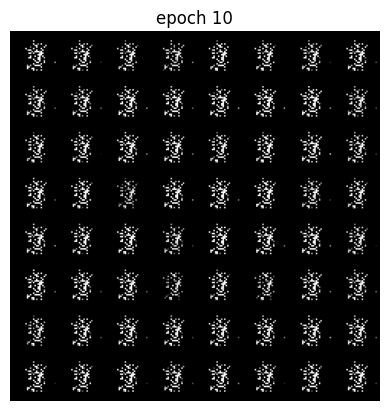

Epoch 10 of 100
Generator loss: 0.69668025, Discriminator loss: 0.69901413


118it [00:21,  5.46it/s]                         


Epoch 11 of 100
Generator loss: 0.69121116, Discriminator loss: 0.71870780


118it [00:19,  6.12it/s]                         


Epoch 12 of 100
Generator loss: 0.67744946, Discriminator loss: 0.78260279


118it [00:20,  5.68it/s]                         


Epoch 13 of 100
Generator loss: 0.67843032, Discriminator loss: 0.79777694


118it [00:21,  5.54it/s]                         


Epoch 14 of 100
Generator loss: 0.62244886, Discriminator loss: 1.00108039


118it [00:21,  5.45it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


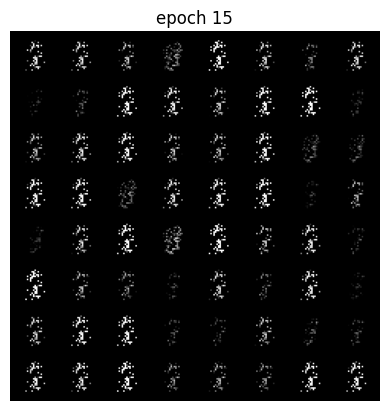

Epoch 15 of 100
Generator loss: 0.62963176, Discriminator loss: 0.97974396


118it [00:20,  5.65it/s]                         


Epoch 16 of 100
Generator loss: 0.66254336, Discriminator loss: 0.84398264


118it [00:18,  6.25it/s]                         


Epoch 17 of 100
Generator loss: 0.67411315, Discriminator loss: 0.79226428


118it [00:18,  6.25it/s]                         


Epoch 18 of 100
Generator loss: 0.68094409, Discriminator loss: 0.74231249


118it [00:19,  6.19it/s]                         


Epoch 19 of 100
Generator loss: 0.67497635, Discriminator loss: 0.76785648


118it [00:22,  5.26it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


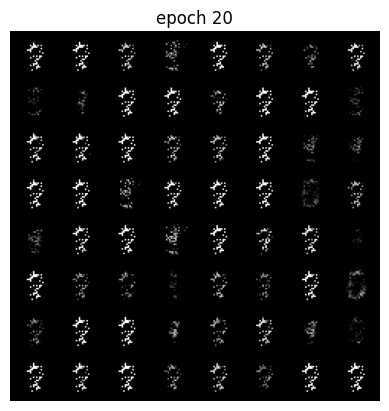

Epoch 20 of 100
Generator loss: 0.68256640, Discriminator loss: 0.74248302


118it [00:20,  5.88it/s]                         


Epoch 21 of 100
Generator loss: 0.68189716, Discriminator loss: 0.74210900


118it [00:19,  6.14it/s]                         


Epoch 22 of 100
Generator loss: 0.67917502, Discriminator loss: 0.74854690


118it [00:20,  5.77it/s]                         


Epoch 23 of 100
Generator loss: 0.67162859, Discriminator loss: 0.76956224


118it [00:19,  5.96it/s]                         


Epoch 24 of 100
Generator loss: 0.66782689, Discriminator loss: 0.80360609


118it [00:18,  6.39it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


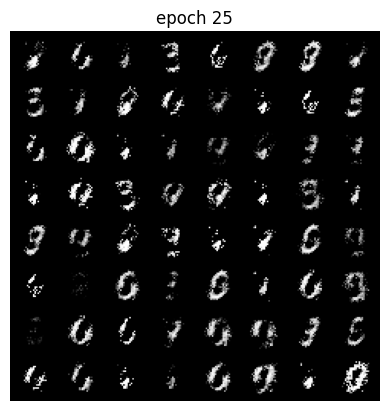

Epoch 25 of 100
Generator loss: 0.64782095, Discriminator loss: 0.89842170


118it [00:19,  5.94it/s]                         


Epoch 26 of 100
Generator loss: 0.66353637, Discriminator loss: 0.83871371


118it [00:23,  5.13it/s]                         


Epoch 27 of 100
Generator loss: 0.64558893, Discriminator loss: 0.87600946


118it [00:20,  5.86it/s]                         


Epoch 28 of 100
Generator loss: 0.65999120, Discriminator loss: 0.82672751


118it [00:19,  6.12it/s]                         


Epoch 29 of 100
Generator loss: 0.64223504, Discriminator loss: 0.89192402


118it [00:20,  5.78it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


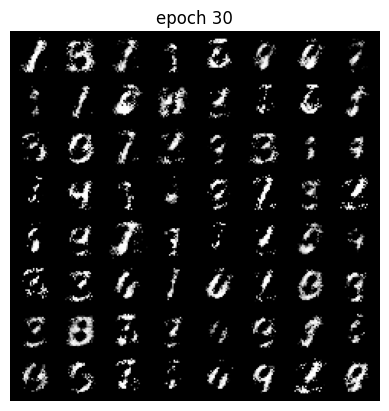

Epoch 30 of 100
Generator loss: 0.64002913, Discriminator loss: 0.89057624


118it [00:19,  6.12it/s]                         


Epoch 31 of 100
Generator loss: 0.64911479, Discriminator loss: 0.87735367


118it [00:18,  6.24it/s]                         


Epoch 32 of 100
Generator loss: 0.64066023, Discriminator loss: 0.91474247


118it [00:20,  5.63it/s]                         


Epoch 33 of 100
Generator loss: 0.64320934, Discriminator loss: 0.88438702


118it [00:25,  4.67it/s]                         


Epoch 34 of 100
Generator loss: 0.63697332, Discriminator loss: 0.91329998


118it [00:19,  5.99it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


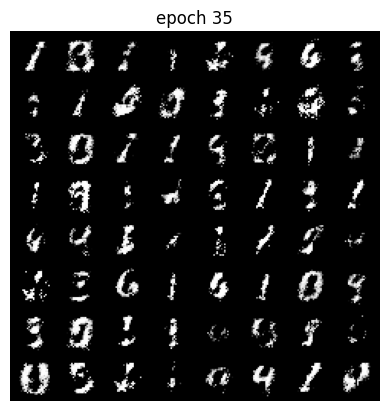

Epoch 35 of 100
Generator loss: 0.64075470, Discriminator loss: 0.89954126


118it [00:18,  6.24it/s]                         


Epoch 36 of 100
Generator loss: 0.63574195, Discriminator loss: 0.91424221


118it [00:18,  6.22it/s]                         


Epoch 37 of 100
Generator loss: 0.63420165, Discriminator loss: 0.93094867


118it [00:19,  6.14it/s]                         


Epoch 38 of 100
Generator loss: 0.63114750, Discriminator loss: 0.93573868


118it [00:19,  6.08it/s]                         


Epoch 39 of 100
Generator loss: 0.63002932, Discriminator loss: 0.92615867


118it [00:19,  6.09it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


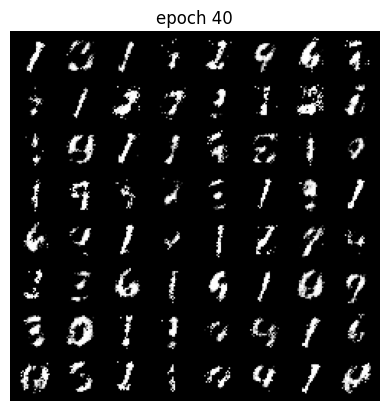

Epoch 40 of 100
Generator loss: 0.63036776, Discriminator loss: 0.93605119


118it [00:19,  5.97it/s]                         


Epoch 41 of 100
Generator loss: 0.62845272, Discriminator loss: 0.93761045


118it [00:25,  4.60it/s]                         


Epoch 42 of 100
Generator loss: 0.62244308, Discriminator loss: 0.96987987


118it [00:20,  5.84it/s]                         


Epoch 43 of 100
Generator loss: 0.61883032, Discriminator loss: 0.96792531


118it [00:20,  5.62it/s]                         


Epoch 44 of 100
Generator loss: 0.62704283, Discriminator loss: 0.94152749


118it [00:19,  6.03it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


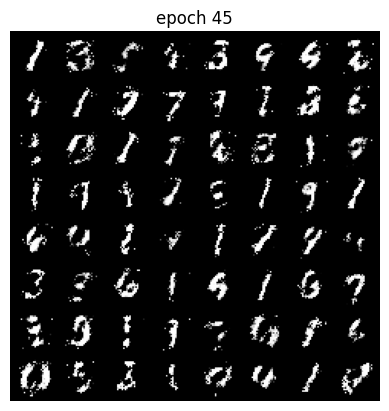

Epoch 45 of 100
Generator loss: 0.62252361, Discriminator loss: 0.95431894


118it [00:19,  6.01it/s]                         


Epoch 46 of 100
Generator loss: 0.61966562, Discriminator loss: 0.95666134


 48%|████▊     | 56/117 [00:13<00:08,  6.83it/s]

In [ ]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return -torch.mean(torch.log(output))

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    rv1 = torch.mean(torch.log(discriminator.forward(true_label)))
    rv2 = torch.mean(torch.log(torch.ones(output.size(dim=0)) - output))
    return -(rv1 + rv2)

torch.autograd.set_detect_anomaly(True)


for epoch in range(epochs):
    t_loss_g = 0.0
    t_loss_d = 0.0
    length = len(train_loader)
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########
        generated_img = generator.forward(create_noise(sample_size, nz))
        critiqued_img = discriminator.forward(generated_img)

        optim_d.zero_grad()
        loss_d = discriminator_loss(critiqued_img, data[0])
        loss_d.backward(retain_graph=True)

        optim_g.zero_grad()
        loss_g = generator_loss(critiqued_img, data[0])
        loss_g.backward()

        optim_d.step()
        optim_g.step()

        t_loss_d += loss_d
        t_loss_g += loss_g

        # print(loss_g)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = t_loss_g / length # total generator loss for the epoch
    epoch_loss_d = t_loss_d / length # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')

In [ ]:
torch.save(generator.state_dict(), "generator_weights.pt")
torch.save(discriminator.state_dict(), "discriminator_weights.pt")
    # save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')